# MIPD of warfarin

In [1]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

## Visualise demographics of trial cohort

StopIteration: 

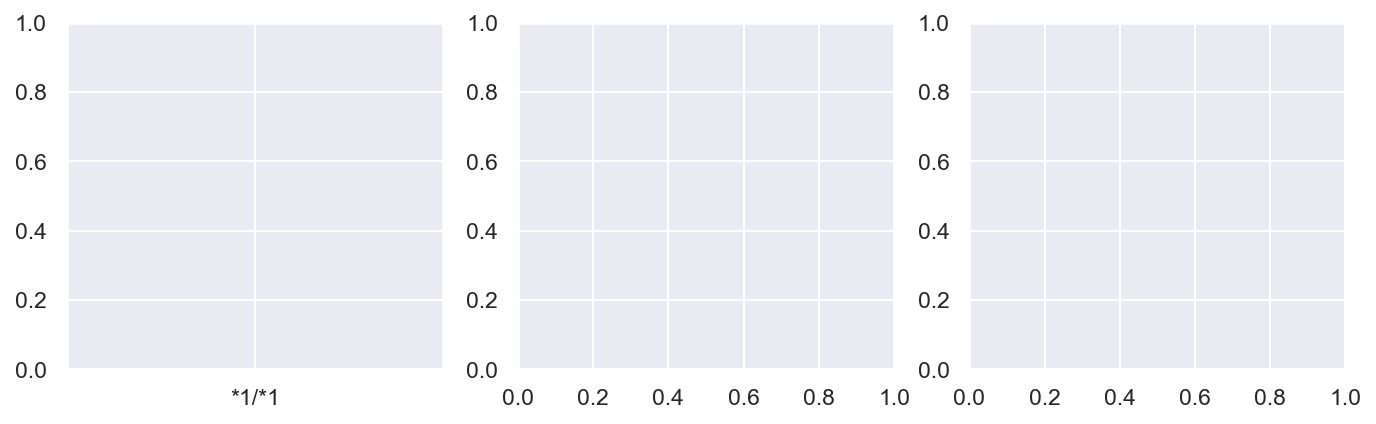

In [2]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.savefig('7_mipd_trial_demographics.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_demographics.tif', bbox_inches='tight')

plt.show()

## Evaluate optimal dosing strategy

This establishes a "best case scenario" where our model captures the
dose response perfectly.

Define utility function that implement IOV and EV

In [4]:
def get_vk_consumption(days, nids, seed):
    """
    Returns deviations of the vk consumption from the mean consumption drawn
    from a normal distribution of shape (days, n_ids).
    """
    rng = np.random.default_rng(seed)
    vk_input = rng.normal(loc=1, scale=0.1, size=(days, nids))

    return vk_input


def define_dosing_regimen(doses, delays, cal_time=100*24):
    """
    Returns a dosing regimen with delayed administration times.
    """
    duration = 0.01
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses):
        if dose == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dose/duration,
            start=cal_time+day*24+delays[day],
            duration=duration))

    return regimen

Simulate INR response for optimal dosing strategy

In [396]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.getcwd()
df_doses = pd.read_csv(directory + '/mipd_trial_optimal_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        if dr == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(dosing_regimens.keys()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[_id])

    # Simulate treatment response
    mask = ids == _id
    try:
        inrs[idx] = model.simulate(parameters=parameters[mask][0], times=times)
    except TypeError:
        print(_id)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


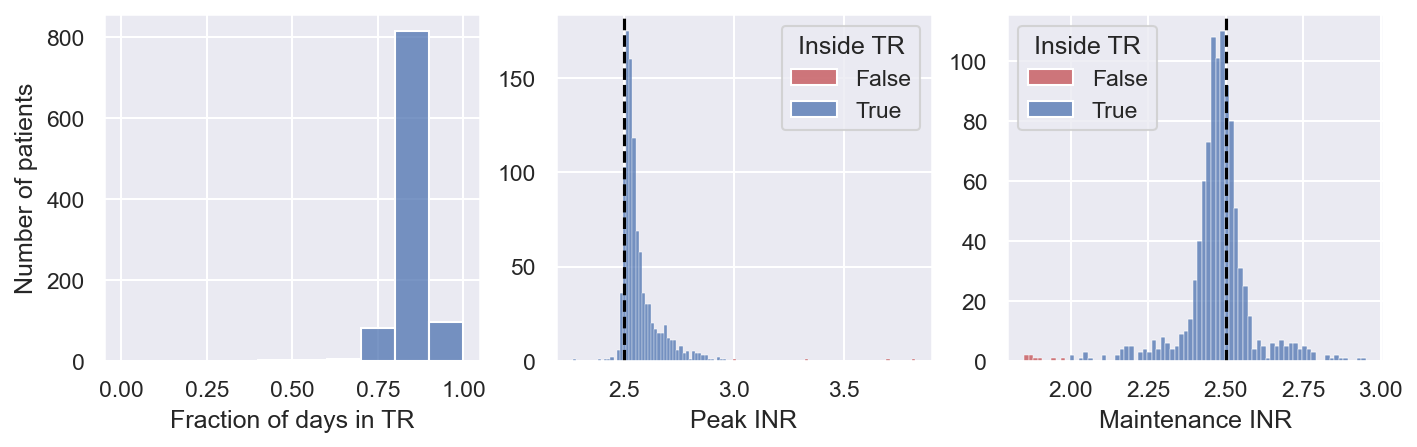

In [397]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()

Visualise dosing regimens

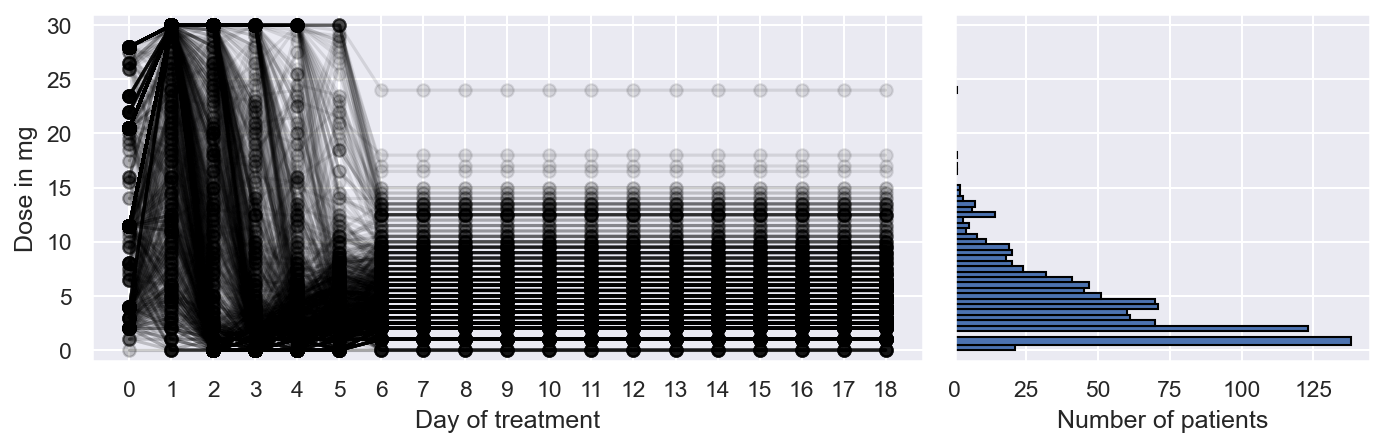

In [398]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25,
        16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25,
        21.75, 22.25, 22.75, 23.25, 23.75, 24.25, 24.75, 25.25, 25.75, 26.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 31])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 31])
axes[1].set_ylabel('')

plt.show()

## Evaluate linear regression model

Simulate INR response for predicted dosing regimens

In [5]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_linear_regression_model'
    '/mipd_trial_predicted_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = np.array(
        [10, 7.5, 5]
        + [temp['Maintenance dose'].values[0]] * (days-3))

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_1 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_1[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


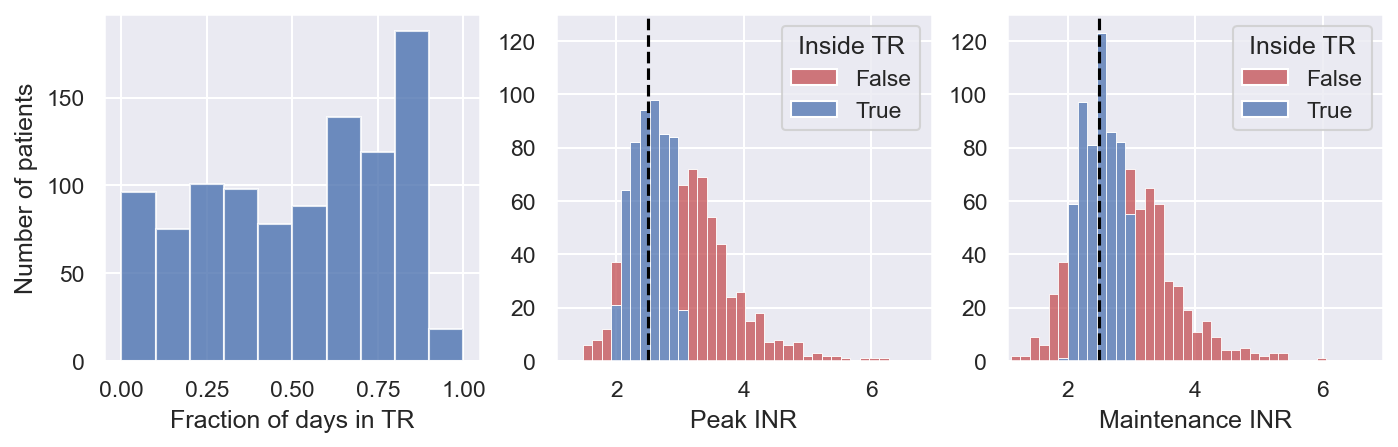

In [26]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
axes[0].hist(
    ttr, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    color=sns.color_palette()[0], alpha=0.8)

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.95])
axes[1].set_ylim([0, 130])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 6.95])
axes[2].set_ylim([0, 130])

plt.savefig('7_mipd_trial_results_linear_regression.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_results_linear_regression.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

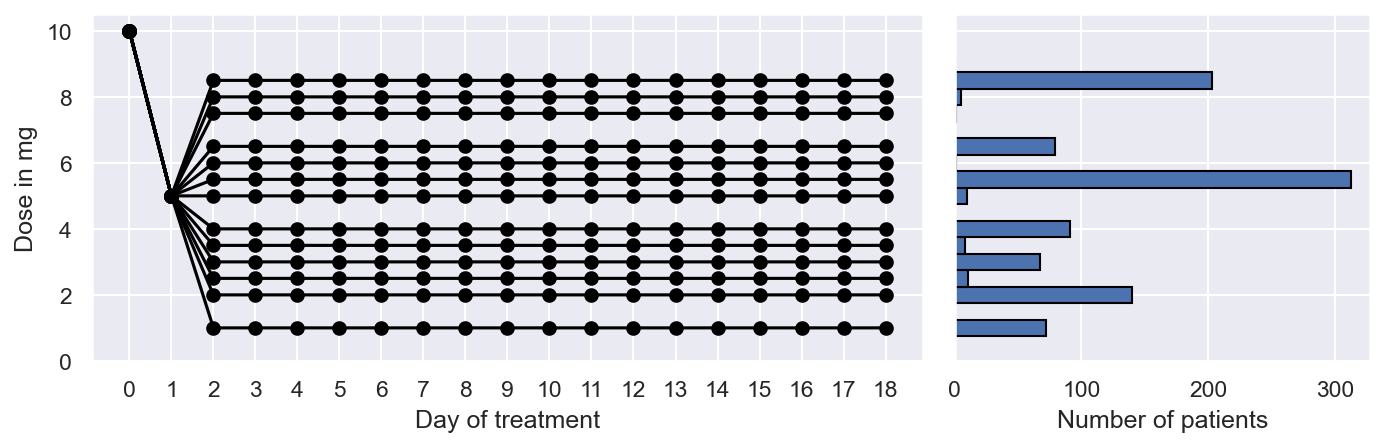

In [300]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    if str(d[-1]) in maintenance_dose.keys():
        maintenance_dose[str(d[-1])] += 1
        continue
    axes[0].plot(np.arange(days), d, marker='o', color='black')
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([0, 10.5])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([0, 10.5])
axes[1].set_ylabel('')


plt.show()

## Evaluate PKPD model (covariates only)

Simulate INR response for predicted dosing regimens

In [34]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 0]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_2 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_2[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


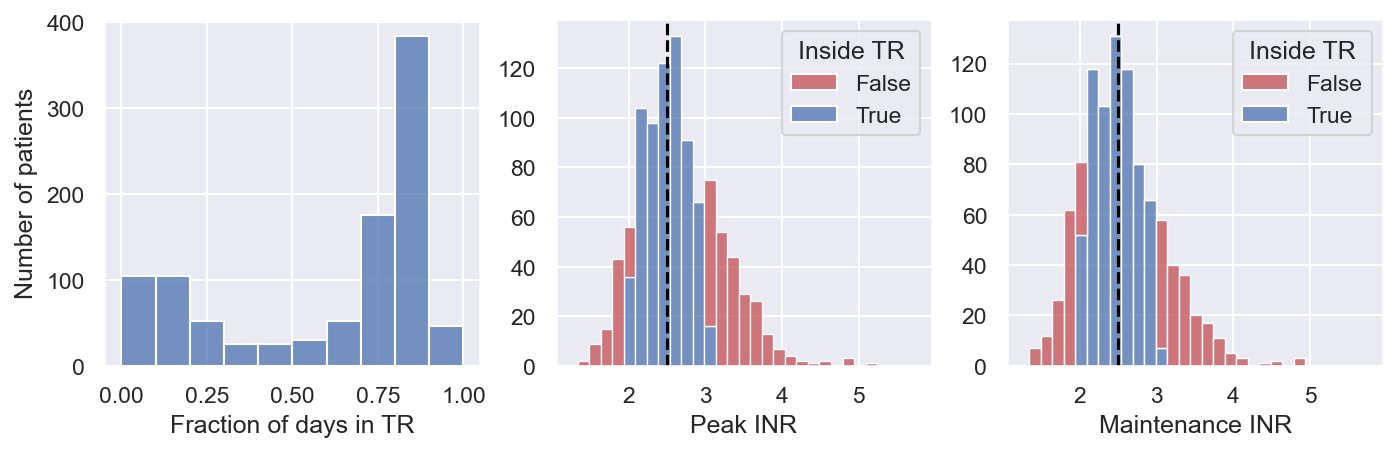

In [35]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 5.95])

plt.savefig('8_mipd_trial_results_pkpd_model_covariates_only.pdf', bbox_inches='tight')
plt.savefig('8_mipd_trial_results_pkpd_model_covariates_only.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

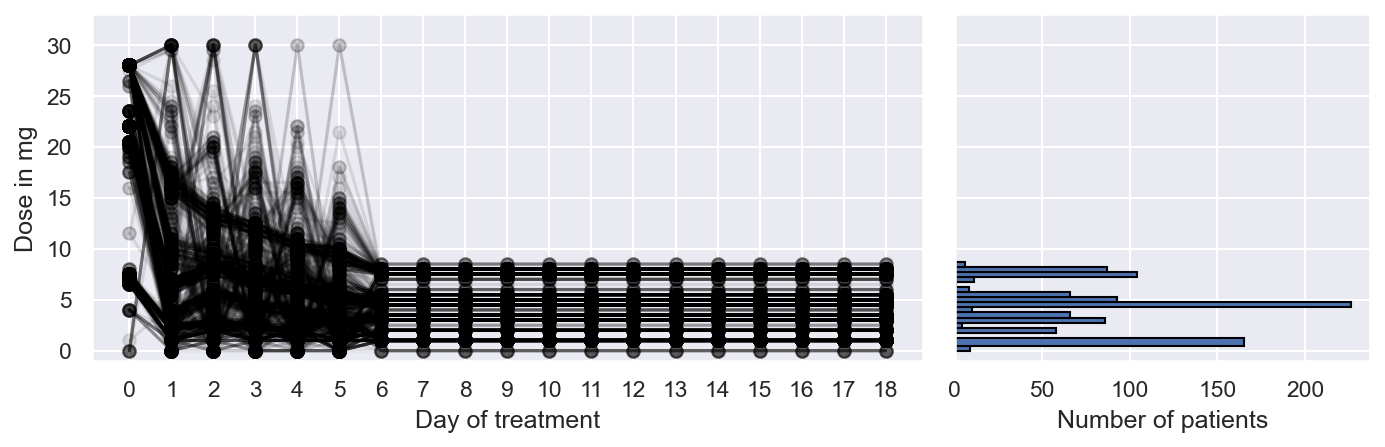

In [7]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')


plt.show()

## Evaluate PKPD model (Bayesian dosing regimen optimisation)

After one week

In [36]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 7]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_3 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_3[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


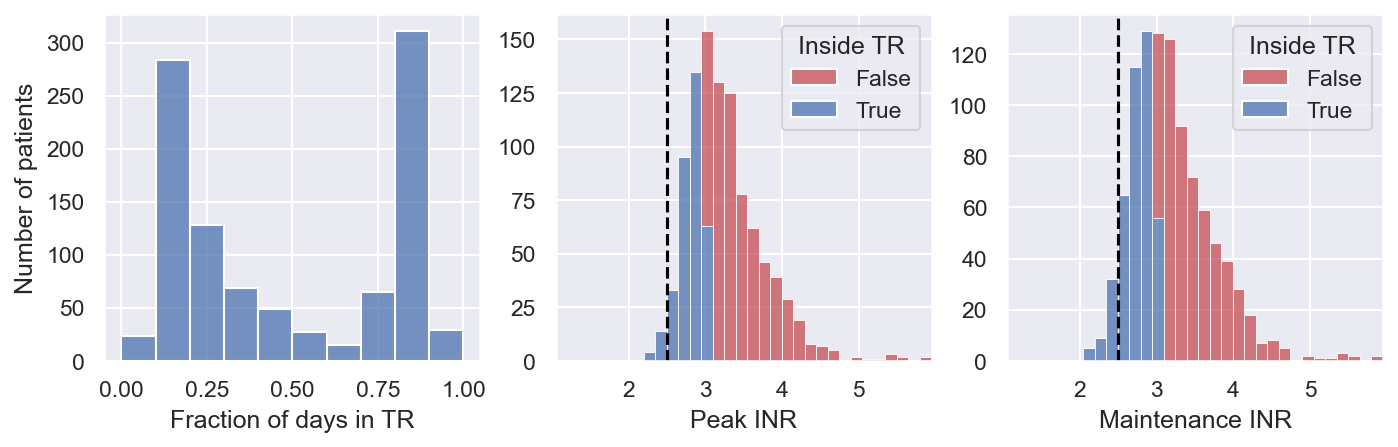

In [37]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 5.95])

plt.savefig(
    '9_mipd_trial_results_bayesian_dosing_regimen_optimisation.pdf',
    bbox_inches='tight')
plt.savefig(
    '9_mipd_trial_results_bayesian_dosing_regimen_optimisation.tif',
    bbox_inches='tight')

plt.show()

After 1 measurement

In [ ]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 1]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_4 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_4[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

After 2 measurements

In [56]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 2]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_6 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_6[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

After 8 measurements

In [61]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 8]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_5 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_5[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

After 9 measurements

In [73]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 9]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_9 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_9[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

After 10

In [92]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 10]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs_10 = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs_10[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, 0] <= 0:
                change = 0.5
            if doses[idx, 0] < 2:
                doses[idx, 0] += 2 * change
            else:
                doses[idx, 0] += change

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

## Summary figure

Linear regression and covariate-based MIPD

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

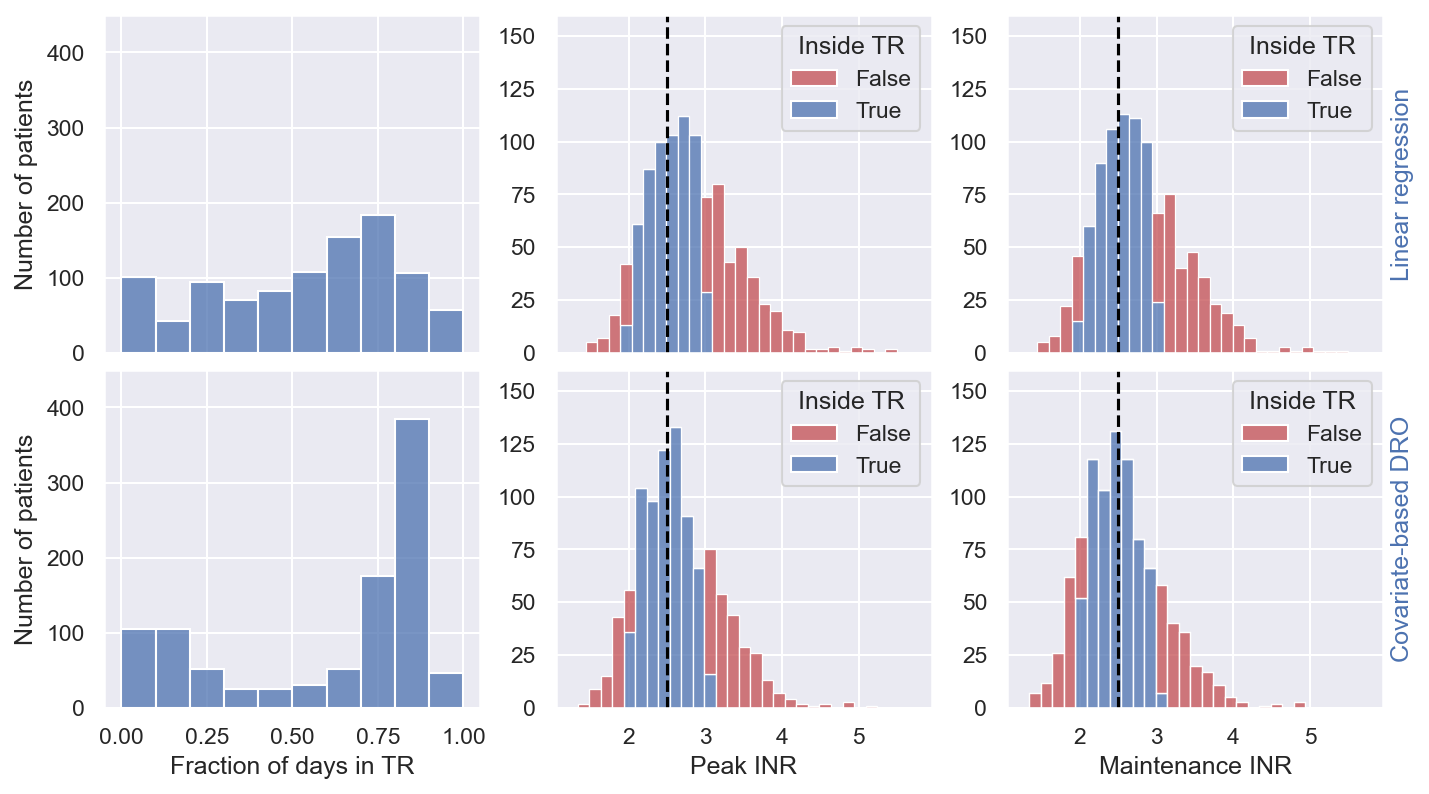

In [52]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 1, hspace=0.05)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.2)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[4].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[5].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 450])
axes[1].set_xlabel('')
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.95])
axes[1].set_ylim([0, 160])
axes[2].set_xlabel('')
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel(
    'Linear regression', color=sns.color_palette()[0])
axes[2].set_xlim([1.05, 5.95])
axes[2].set_ylim([0, 160])
axes[3].set_xlabel('Fraction of days in TR')
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 450])
axes[4].set_xlabel('Peak INR')
axes[4].set_ylabel('')
axes[4].set_xlim([1.05, 5.95])
axes[4].set_ylim([0, 160])
axes[5].set_xlabel('Maintenance INR')
axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel(
    'Covariate-based DRO', color=sns.color_palette()[0])
axes[5].set_xlim([1.05, 5.95])
axes[5].set_ylim([0, 160])

plt.savefig('9_covariate_based_mipd.pdf',
    bbox_inches='tight')
plt.savefig('9_covariate_based_mipd.tif',
    bbox_inches='tight')

plt.show()

Progression of Bayesian dosing regimen optimisation

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

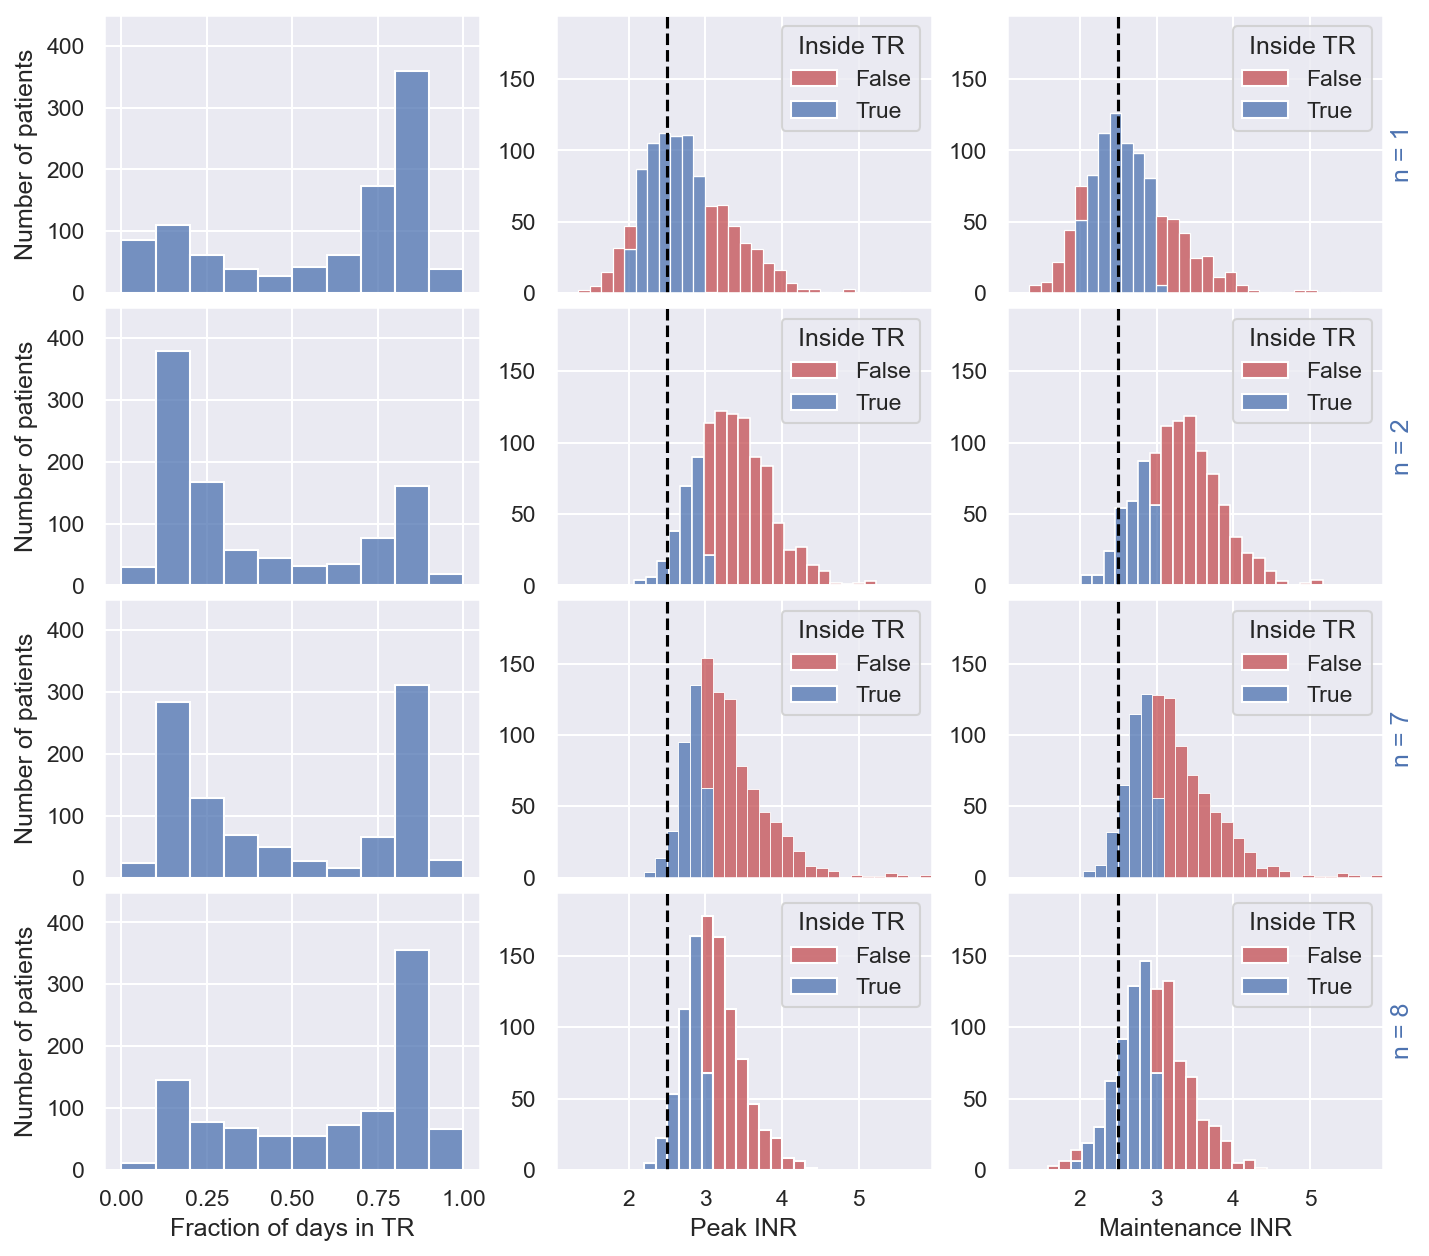

In [65]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 2100 // my_dpi), dpi=150)
outer = gridspec.GridSpec(4, 1, hspace=0.05)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.2)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.2)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.2)
inner4 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[3], wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))
axes.append(plt.Subplot(fig, inner4[0]))
axes.append(plt.Subplot(fig, inner4[1]))
axes.append(plt.Subplot(fig, inner4[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_4 >= 2) & (inrs_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_6 >= 2) & (inrs_6 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_6, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[4].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_6[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[5].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[6], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[7].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[8], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[8].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_5 >= 2) & (inrs_5 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[9], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_5, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[10], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[10].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_5[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[11], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[11].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 450])
axes[1].set_xlabel('')
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.95])
axes[1].set_ylim([0, 195])
axes[2].set_xlabel('')
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel(
    'n = 1', color=sns.color_palette()[0])
axes[2].set_xlim([1.05, 5.95])
axes[2].set_ylim([0, 195])
axes[3].set_xlabel('')
axes[3].set_xticklabels(labels=[], visible=False)
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 450])
axes[4].set_xlabel('')
axes[4].set_xticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.05, 5.95])
axes[4].set_ylim([0, 195])
axes[5].set_xlabel('')
axes[5].set_xticklabels(labels=[], visible=False)
axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel(
    'n = 2', color=sns.color_palette()[0])
axes[5].set_xlim([1.05, 5.95])
axes[5].set_ylim([0, 195])
axes[6].set_xlabel('')
axes[6].set_xticklabels(labels=[], visible=False)
axes[6].set_ylabel('Number of patients')
axes[6].set_xlim([-0.05, 1.05])
axes[6].set_ylim([0, 450])
axes[7].set_xlabel('')
axes[7].set_xticklabels(labels=[], visible=False)
axes[7].set_ylabel('')
axes[7].set_xlim([1.05, 5.95])
axes[7].set_ylim([0, 195])
axes[8].set_xlabel('')
axes[8].set_xticklabels(labels=[], visible=False)
axes[8].yaxis.set_label_position("right")
axes[8].set_ylabel(
    'n = 7', color=sns.color_palette()[0])
axes[8].set_xlim([1.05, 5.95])
axes[8].set_ylim([0, 195])
axes[9].set_xlabel('Fraction of days in TR')
axes[9].set_ylabel('Number of patients')
axes[9].set_xlim([-0.05, 1.05])
axes[9].set_ylim([0, 450])
axes[10].set_xlabel('Peak INR')
axes[10].set_ylabel('')
axes[10].set_xlim([1.05, 5.95])
axes[10].set_ylim([0, 195])
axes[11].set_xlabel('Maintenance INR')
axes[11].yaxis.set_label_position("right")
axes[11].set_ylabel(
    'n = 8', color=sns.color_palette()[0])
axes[11].set_xlim([1.05, 5.95])
axes[11].set_ylim([0, 195])

plt.savefig('10_bayesian_mipd.pdf',
    bbox_inches='tight')
plt.savefig('10_bayesian_mipd.tif',
    bbox_inches='tight')

plt.show()

After 10 measurements

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


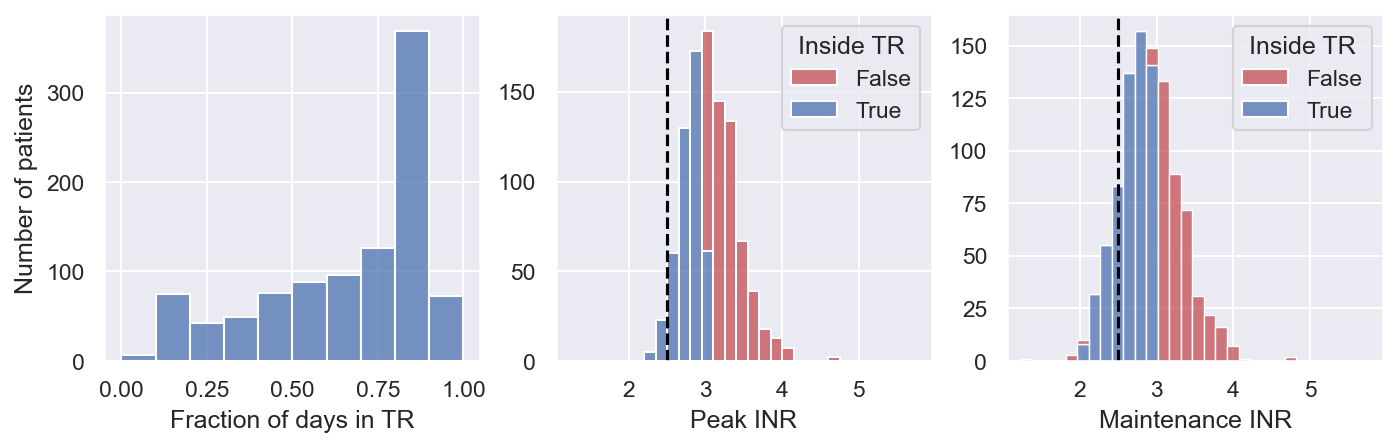

In [94]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_10 >= 2) & (inrs_10 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_10, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_10[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 5.95])

plt.savefig(
    '11_mipd_trial_results_bayesian_dosing_regimen_optimisation.pdf',
    bbox_inches='tight')
plt.savefig(
    '11_mipd_trial_results_bayesian_dosing_regimen_optimisation.tif',
    bbox_inches='tight')

plt.show()

In [69]:
# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)

In [72]:
np.sum(ttr < 0.3)

262

In [76]:
from scipy.stats import expon

In [91]:
expon.ppf(0.5, scale=30)

20.79441541679836

In [99]:
np.where(np.array(model._network_model.parameters()) == 'myokit.input_rate_vk')[0][0]

153